<a href="https://colab.research.google.com/github/laliali20/DSITwist2/blob/main/DSITwist2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project goal and Scope

The objective of the project is to forecast 12 months ahead in time how popular the crypto firm, Kraken, is expected to be. The data considered is the google trend searches as well as wikipedia page visits. Tweets are initally considered but are eventually abandoned due to the complexity in determining a positive tweet from a negative one as well as time-constraint. 

The data from google trend searches as well as wikipedia page visits is scrapped and added into a database from which it is manipulated into a viable time series to use for predicting the project goals. Both the expected wikipedia visits and the google searches forecasts are provided in the project.

# Scraping

In [1]:
!pip install pytrends 

In [2]:
!pip install snscrape

In [3]:
!pip install pageviewapi

In [4]:

#%% Import modules
import datetime
import requests
import pandas as pd
from pytrends import dailydata
import snscrape.modules.twitter as sntwitter
import pageviewapi
import numpy as np
# import mysql.connector

    

## Wikipedia

In [5]:
def get_wikipedia_data(article, from_date, to_date):
    
    """
    Gets wikipedia article page views.
    Dates like: 'YYYYMMDD'
    """
    
    response =  pageviewapi.per_article('en.wikipedia.org', article, from_date, to_date,
                                        access = 'all-access', agent = 'all-agents', granularity = 'monthly')
    
    data = [x['views'] for x in response['items']]
    dates = [x['timestamp'] for x in response['items']]
    
    return pd.DataFrame({'date': dates, 'views': data})


## Google Trends

In [6]:
def get_google_trends_data(keyword, from_date, to_date):
    
    """
    Gets daily Google Trends for keyword.
    Dates like: 'YYYY-MM-DD'
    """
    
    from_year, from_month = datetime.date.fromisoformat(from_date).year, datetime.date.fromisoformat(from_date).month
    to_year, to_month = datetime.date.fromisoformat(to_date).year, datetime.date.fromisoformat(to_date).month

    data = dailydata.get_daily_data(keyword, from_year, from_month, to_year, to_month)
    
    return data[keyword]

## Tweets

In [7]:
# def get_twitter_data(keyword, from_date, to_date):
    
#     """
#     Gets twitter posts containing specific keyword.
#     Dates like: 'YYYY-MM-DD'
    
#     """
#     # Creating list to append tweet data to
#     counts_list = []
#     dates_list = []
    
#     days = pd.date_range(start = from_date, end = to_date)
    
#     for i in range(len(days)-1):
        
#         # Using TwitterSearchScraper to count daily tweets
#         daily_count = 0
#         for item in sntwitter.TwitterSearchScraper(keyword + ' since:' + str(days[i].date()) + ' until:' + str(days[i+1].date())).get_items():
#             daily_count = daily_count + 1
        
#         print("Day", str(days[i].date()), "had:", daily_count, ". Going to next day...")
        
#         dates_list.append(days[i].date())
#         counts_list.append(daily_count)
        
#     return pd.DataFrame({'date': dates_list, 'tweets': counts_list})

## Scaping the desired data

In [8]:

#%% Scrape desired data 

# Get Google data and save them
google = get_google_trends_data('Kraken', '2019-10-01', '2022-02-28')
google.to_csv('google_data.csv')



Kraken:2019-10-01 2019-10-31
Kraken:2019-11-01 2019-11-30
Kraken:2019-12-01 2019-12-31
Kraken:2020-01-01 2020-01-31
Kraken:2020-02-01 2020-02-29
Kraken:2020-03-01 2020-03-31
Kraken:2020-04-01 2020-04-30
Kraken:2020-05-01 2020-05-31
Kraken:2020-06-01 2020-06-30
Kraken:2020-07-01 2020-07-31
Kraken:2020-08-01 2020-08-31
Kraken:2020-09-01 2020-09-30
Kraken:2020-10-01 2020-10-31
Kraken:2020-11-01 2020-11-30
Kraken:2020-12-01 2020-12-31
Kraken:2021-01-01 2021-01-31
Kraken:2021-02-01 2021-02-28
Kraken:2021-03-01 2021-03-31
Kraken:2021-04-01 2021-04-30
Kraken:2021-05-01 2021-05-31
Kraken:2021-06-01 2021-06-30
Kraken:2021-07-01 2021-07-31
Kraken:2021-08-01 2021-08-31
Kraken:2021-09-01 2021-09-30
Kraken:2021-10-01 2021-10-31
Kraken:2021-11-01 2021-11-30
Kraken:2021-12-01 2021-12-31
Kraken:2022-01-01 2022-01-31
Kraken:2022-02-01 2022-02-28


In [9]:
# Get Wikipedia data and save them
wikipedia = get_wikipedia_data('Kraken', '20191001', '20220228')
wikipedia.to_csv('wikipedia_data.csv')

# Create a database

In [10]:
# build db

import sqlite3
sqlite3.connect('db_dsi_twist')

conn = sqlite3.connect('db_dsi_twist') 
c = conn.cursor()

c.execute('''
          CREATE TABLE IF NOT EXISTS google
          (date date, mentions)
          ''')
          
c.execute('''
          CREATE TABLE IF NOT EXISTS wikipedia
          (dateid , mentions)
          ''')
                     
conn.commit()

In [11]:
from sqlalchemy import create_engine
dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')
df_google = pd.read_csv('/content/google_data.csv', sep = ',', parse_dates=['date'], date_parser=dateparse)
df_wiki = pd.read_csv('/content/wikipedia_data.csv', sep = ',')

df_google.to_sql('google_data',  conn, if_exists='replace', index=False)
df_wiki.to_sql('wiki_data',  conn, if_exists='replace', index=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2882: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


# Read from the database

In [12]:
google_query = '''
select * 
from google_data
'''

wiki_query = '''
select * 
from wiki_data
'''

df1 = pd.read_sql(google_query, conn )
df2 = pd.read_sql(wiki_query, conn)
df2

,Unnamed: 0,date,views
0,0,2019100100,66833
1,1,2019110100,65284
2,2,2019120100,61757
3,3,2020010100,89528
4,4,2020020100,65809
5,5,2020030100,62899
6,6,2020040100,73262
7,7,2020050100,74209
8,8,2020060100,76217
9,9,2020070100,420186


# Model fitting




In [13]:
# forecast input
std_date = lambda x: str(str(x)[0:4]) + "-" + str(str(x)[4:6]) + "-01"
std_date2 = lambda x: str(str(x)[0:7]) + "-01"
df2['temp_date'] = df2['date'].apply(std_date)
df1['temp_date'] = df1['date'].apply(std_date2)
df1_in = df1.groupby('temp_date').agg({'Kraken':'sum'}).sort_values('temp_date').reset_index()
df2_in = df2.groupby('temp_date').agg({'views':'sum'}).sort_values('temp_date').reset_index()

In [14]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import Holt
from statsmodels.tsa.stattools import adfuller


def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Google Trends Dataset

Check for starionarity

In [15]:
adfuller_test(df1_in['Kraken'].to_list())

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9594
 No. Lags Chosen       = 0
 Critical value 1%     = -3.689
 Critical value 5%     = -2.972
 Critical value 10%    = -2.625
 => P-Value = 0.0389. Rejecting Null Hypothesis.
 => Series is Stationary.


Split datasets into training and testing sets

In [16]:
holdout = len(df1_in) - 12
nobs_train = [i for i in range(0, holdout)]
nobs_test = [i for i in range(holdout, len(df1_in))]
train_goog = df1_in.iloc[nobs_train]
test_goog = df1_in.iloc[nobs_test]

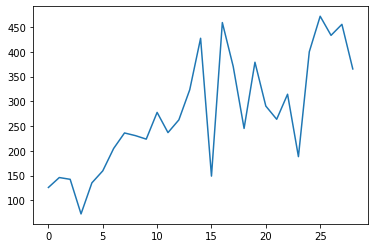

In [17]:
import matplotlib.pyplot as plt

plt.plot(df1_in['Kraken'])
plt.show()

In [18]:
adfuller_test(df2_in['views'].to_list())

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1743
 No. Lags Chosen       = 3
 Critical value 1%     = -3.724
 Critical value 5%     = -2.986
 Critical value 10%    = -2.633
 => P-Value = 0.2157. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


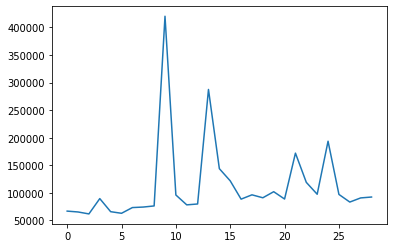

In [19]:
plt.plot(df2_in['views'])
plt.show()

In [20]:
fit_goog_test = Holt(train_goog['Kraken']).fit(optimized=True)
fcast_goog_test = fit_goog_test.forecast(12)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Compute accuracy

In [21]:
def compute_MAPE(act, fcast):
  err = np.zeros(len(act))
  for i in range(len(act)):
    err[i] = (abs(act[i] - fcast[i]))/act[i]
  return err.mean()

## Wikipedia views dataset

In [22]:
holdout = len(df1_in) - 12
nobs_train = [i for i in range(0, holdout)]
nobs_test = [i for i in range(holdout, len(df1_in))]
train_wiki = df2_in.iloc[nobs_train]
test_wiki = df2_in.iloc[nobs_test]

In [23]:
fit_wiki = Holt(train_wiki['views']).fit(optimized=True)
fcast_wiki_test = fit_wiki.forecast(12)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


# Forecast 

In [24]:
fit_goog = Holt(df1_in['Kraken']).fit(optimized=True)
fit_wiki = Holt(df2_in['views']).fit(optimized=True)
forecast_goog = fit_goog.forecast(12)
forecast_wiki = fit_wiki.forecast(12)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


# Dashboard prep

In [25]:
! pip install dash   
! pip install dash-html-components                                         
! pip install dash-core-components                                     
! pip install plotly

In [26]:
fcast_dates = ['2022-03-01','2022-04-01','2022-05-01','2022-06-01','2022-07-01','2022-08-01','2022-09-01','2022-10-01','2022-11-01','2022-12-01','2023-01-01','2023-02-01']

In [27]:
df1_out = pd.DataFrame({'date': fcast_dates, 'Kraken':  forecast_goog}) 
df2_out = pd.DataFrame({'date': fcast_dates, 'views':  forecast_wiki})

In [28]:
df2_out.to_sql('wiki_forecast',  conn, if_exists='replace', index=False)
df1_out.to_sql('goog_forecast',  conn, if_exists='replace', index=False)

In [29]:
df2_in.to_sql('wiki_input',  conn, if_exists='replace', index=False)
df1_in.to_sql('goog_input',  conn, if_exists='replace', index=False)

In [30]:
wiki_query = '''
SELECT * 
FROM wiki_input
union
SELECT * 
from wiki_forecast
'''

goog_query = '''
SELECT * 
FROM goog_input
union
SELECT * 
from goog_forecast
'''

wiki_fin = pd.read_sql(wiki_query, conn )
goog_fin = pd.read_sql(goog_query, conn )

In [31]:
wiki_fin.to_csv('wiki.csv')
goog_fin.to_csv('goog.csv')

In [32]:
wiki_fin

,temp_date,views
0,2019-10-01,66833.000000
1,2019-11-01,65284.000000
2,2019-12-01,61757.000000
3,2020-01-01,89528.000000
4,2020-02-01,65809.000000
5,2020-03-01,62899.000000
6,2020-04-01,73262.000000
7,2020-05-01,74209.000000
8,2020-06-01,76217.000000
9,2020-07-01,420186.000000


In [33]:
goog_fin

,temp_date,Kraken
0,2019-10-01,126.180000
1,2019-11-01,146.190000
2,2019-12-01,142.600000
3,2020-01-01,72.770000
4,2020-02-01,135.480000
5,2020-03-01,159.670000
6,2020-04-01,204.840000
7,2020-05-01,236.160000
8,2020-06-01,230.790000
9,2020-07-01,223.720000
